# Sprint_1 機械学習フロー

**【工程】**
1. 事前学習で作成したベースラインモデルを展開する。 
    1. データの前処理
        1. csvファイルの読み出し
        2. objectをlabel/one-hot変換して数値化
        3. 異常値の処置
        4. 欠損値の処置
    2. 説明変数を選抜
        1. 相関係数を算出
        2. 高い相関性を4つ選択
2. hold-out法ではなく、cross validationを行う。
    1. scikit-learnのkFoldクラスを用いる
    2. cross_val_scoreにて精度を確認する
3. それ以降（学習・推定）は行わない。

In [1]:
# numpy and pandas for data manipulation
import numpy as np
import pandas as pd 

# sklearn preprocessing for dealing with categorical variables
from sklearn.preprocessing import LabelEncoder

# File system manangement
import os

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

## データの前処理
### csvファイルの読み出し

In [2]:
# csvファイルの読み出し

app_train = pd.read_csv('../../application_train.csv')
app_test = pd.read_csv('../../application_test.csv')

print('Training data shape: ', app_train.shape)
app_train.head()

Training data shape:  (307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


## object型をlabel/one-hot変換してint化

In [3]:
# objectをlabel/one-hot変換して数値化

# Create a label encoder object
le = LabelEncoder()
le_count = 0

# Iterate through the columns
for col in app_train:
    if app_train[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(app_train[col].unique())) <= 2:
            # Train on the training data
            le.fit(app_train[col])
            # Transform both training and testing data
            app_train[col] = le.transform(app_train[col])
            app_test[col] = le.transform(app_test[col])
            
            # Keep track of how many columns were label encoded
            le_count += 1
            
print('%d columns were label encoded.' % le_count)

3 columns were label encoded.


In [4]:
# one-hot encoding of categorical variables
app_train = pd.get_dummies(app_train)
app_test = pd.get_dummies(app_test)

print('Training Features shape: ', app_train.shape)
print('Testing Features shape: ', app_test.shape)

train_labels = app_train['TARGET']

# Align the training and testing data, keep only columns present in both dataframes
app_train, app_test = app_train.align(app_test, join = 'inner', axis = 1)

# Add the target back in
app_train['TARGET'] = train_labels

print('Training Features shape: ', app_train.shape)
print('Testing Features shape: ', app_test.shape)

Training Features shape:  (307511, 243)
Testing Features shape:  (48744, 239)
Training Features shape:  (307511, 240)
Testing Features shape:  (48744, 239)


## 異常値の排除

In [5]:
# Skipping anomalies

# Create an anomalous flag column
app_train['DAYS_EMPLOYED_ANOM'] = app_train["DAYS_EMPLOYED"] == 365243

# Replace the anomalous values with nan
app_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

app_test['DAYS_EMPLOYED_ANOM'] = app_test["DAYS_EMPLOYED"] == 365243
app_test["DAYS_EMPLOYED"].replace({365243: np.nan}, inplace = True)

print('There are %d anomalies in the test data out of %d entries' % (app_test["DAYS_EMPLOYED_ANOM"].sum(), len(app_test)))

There are 9274 anomalies in the test data out of 48744 entries


## 欠損値の処置

In [6]:
# imputer for handling missing values
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(missing_values=np.nan, strategy = 'median')

X = np.array(app_train[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']])
y = np.array(app_train[['TARGET']])

X = imputer.fit_transform(X)
pd_X = pd.DataFrame(X)
pd_X

,0,1,2,3
0,0.083037,0.262949,0.139376,-9461.0
1,0.311267,0.622246,0.535276,-16765.0
2,0.505998,0.555912,0.729567,-19046.0
3,0.505998,0.650442,0.535276,-19005.0
4,0.505998,0.322738,0.535276,-19932.0
...,...,...,...,...
307506,0.145570,0.681632,0.535276,-9327.0
307507,0.505998,0.115992,0.535276,-20775.0
307508,0.744026,0.535722,0.218859,-14966.0
307509,0.505998,0.514163,0.661024,-11961.0


In [7]:
# 欠損値の確認
print(pd_X.isnull().any())

print('Training data shape: ', X.shape)
print('Testing data shape: ', y.shape)

0    False
1    False
2    False
3    False
dtype: bool
Training data shape:  (307511, 4)
Testing data shape:  (307511, 1)


## 説明変数を選抜

### 相関係数を算出
（欠損値の処置前のデータ, 'app_train'を使用）

In [8]:
# Find correlations with the target and sort
correlations = app_train.corr()['TARGET'].sort_values()

# Display correlations
print('Most Positive Correlations:\n', correlations.tail(15))
print('\nMost Negative Correlations:\n', correlations.head(15))

Most Positive Correlations:
 OCCUPATION_TYPE_Laborers                             0.043019
FLAG_DOCUMENT_3                                      0.044346
REG_CITY_NOT_LIVE_CITY                               0.044395
FLAG_EMP_PHONE                                       0.045982
NAME_EDUCATION_TYPE_Secondary / secondary special    0.049824
REG_CITY_NOT_WORK_CITY                               0.050994
DAYS_ID_PUBLISH                                      0.051457
CODE_GENDER_M                                        0.054713
DAYS_LAST_PHONE_CHANGE                               0.055218
NAME_INCOME_TYPE_Working                             0.057481
REGION_RATING_CLIENT                                 0.058899
REGION_RATING_CLIENT_W_CITY                          0.060893
DAYS_EMPLOYED                                        0.074958
DAYS_BIRTH                                           0.078239
TARGET                                               1.000000
Name: TARGET, dtype: float64

Most Negati

### 高い相関性を4つ選択

In [9]:
# Extract the EXT_SOURCE variables and show correlations

ext_data = app_train[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]
ext_data_corrs = ext_data.corr()
ext_data_corrs

,TARGET,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH
TARGET,1.000000,-0.155317,-0.160472,-0.178919,0.078239
EXT_SOURCE_1,-0.155317,1.000000,0.213982,0.186846,-0.600610
EXT_SOURCE_2,-0.160472,0.213982,1.000000,0.109167,-0.091996
EXT_SOURCE_3,-0.178919,0.186846,0.109167,1.000000,-0.205478
DAYS_BIRTH,0.078239,-0.600610,-0.091996,-0.205478,1.000000


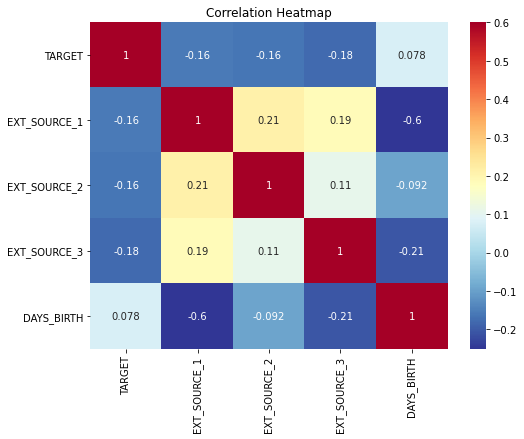

In [10]:
plt.figure(figsize = (8, 6))

# Heatmap of correlations
sns.heatmap(ext_data_corrs, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Heatmap');

* As the value of the EXT_SOURCE increases, the client is more likely to repay the loan.
* There does appear to be a moderate positive linear relationship between the EXT_SOURCE_1 and the DAYS_BIRTH (or equivalently YEARS_BIRTH)

# 【問題1】クロスバリデーション

事前学習期間の課題で作成したベースラインモデルに対応したKFoldクラスによる訓練と交差検証（クロスバリデーション）で評価を行うパイプラインを作成する。

## hold-out法ではなく、cross_validationを行う

### scikit-learnのkFoldクラスを用いる
* n_splits = 2回、分割する。
* random_state = 0で固定

In [11]:
from sklearn.model_selection import KFold
from sklearn.pipeline import make_pipeline

kf = KFold(n_splits=2, shuffle=False, random_state=0)

# 各Xとyのtrainとtestにsplitする。
# これがhold-out法である。
for train_index, test_index in kf.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

TRAIN: [153756 153757 153758 ... 307508 307509 307510] TEST: [     0      1      2 ... 153753 153754 153755]
TRAIN: [     0      1      2 ... 153753 153754 153755] TEST: [153756 153757 153758 ... 307508 307509 307510]


## cross_val_scoreにて精度を確認する（Shortened）

cross_val_score（交差検証）
* classifier（分類器）と、トレーニング用データ、テスト用データ、何分割にして検証するかを指定して、その精度を割り出す。
* ネストした交差検証でおこなえることは、あくまで「あるモデルのあるデータに対する評価」であり、「良い予測モデルの構築」そのものではない。

In [18]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

standardizer = StandardScaler()
logit = LogisticRegression()
pipeline = make_pipeline(standardizer, logit)

# ランダムフォレストを採用（乱数を0で固定）
model = RandomForestClassifier(n_estimators=100, random_state=0)

scores = cross_val_score(model, X, y, cv=kf, scoring="roc_auc")
scores_2 = cross_val_score(pipeline,
                          X,
                          y,
                          cv=kf,
                          scoring="roc_auc"
                          )

print("精度検証の平均値は{:.3f}".format(scores.mean()))
print("精度検証2の平均値は{:.3f}".format(scores_2.mean()))

df = pd.DataFrame(scores)

精度検証の平均値は0.665
精度検証2の平均値は0.719


# 【問題2】グリッドサーチ

1. scikit-learnのGridSearchCVを使い、グリッドサーチを行うコードを作成してください。
2. ベースラインモデルに対して何らかしらのパラメータチューニングを行なってください。



## GridSearchCVを行い、最適なパラメーターを算出

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

model=RandomForestClassifier(random_state=0)
params = {'n_estimators'  : [3, 10, 100, 1000, 10000], 'n_jobs': [-1]}
kf = KFold(n_splits=2, random_state=None, shuffle=False)


GridSearch = GridSearchCV(estimator=model, param_grid=params, cv=kf, scoring="roc_auc", n_jobs=1, pre_dispatch='2*n_jobs')

GridSearch.fit(X, y)

print("Best Model Parameter: ", GridSearch.best_params_)

## ベースラインモデルへのパラメーターの適応

In [ ]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(GridSearch, X_train, y_train, cv = kf)
df = pd.DataFrame(scores)

print("最適なパラメーターを適応後の精度検証の平均値は{:.3f}".format(scores.mean()))

df

# 【問題3】Kaggle Notebooksからの調査

KaggleのNotebooksから様々なアイデアを見つけ出して、列挙してください。

* 異常値の処置（適応済み）
    * Anomalies（異常値）は原因は様々
    * 最も安全な処置としては、欠損値として扱い、後の欠損値の処置に廻す。（平均値で補完する）
* object型のint化（適応済み）
    * 二値の場合はlabel encoding、二値以上の場合はone-hot encodingでカラム数を増やす。
* 欠損値の処置（適応済み）
    * SimpleImputerを用い、欠損値(NaN）に平均値を代入して補完する。
* 相関係数行列（適応済み）
    * 欠損値の処置の前に行う。
* polynomical_features (多項式回帰）因果変数同士の組み合わせ 
    * 結果（目的変数）に対して、個々の説明変数の因果関係は乏しくとも、組み合わせにより相関性が向上する。
* Light Gradient Boosting Machine (LightGBM)
    * L・G・B・M！

## 【問題4】高い汎化性能のモデル作成

比較対象
* ランダムフォレスト回帰を用いたモデルの精度
* 多項式回帰を用いたモデルの精度
* ~~LightGBMを適応したモデルの精度~~

作業順序（全てGridSearchCVを用いる）
1. ランダムフォレストのcross_val_score算出
2. 多項式回帰適応した上でのランダムフォレスト回帰後のcross_val_score算出
3. ~~LightGBM適応のcross_val_score算出~~

## ランダムフォレスト回帰の精度算出

In [ ]:
# ランダムフォレストを用いたGridsearchCVを行った場合の精度算出

model=RandomForestClassifier(random_state=0)
params = {'n_estimators'  : [3, 10, 100, 1000, 10000], 'n_jobs': [-1]}
kf = KFold(n_splits=2, random_state=None, shuffle=False)

GridSearch = GridSearchCV(estimator=model, param_grid=params, cv=kf, scoring="roc_auc", n_jobs=1, pre_dispatch='2*n_jobs')


GridSearch.fit(X_train, y_train)

scores = cross_val_score(GridSearch, X_train, y_train, cv = kf)
df = pd.DataFrame(scores)

print("最適なパラメーターを適応後の精度検証の平均値は{:.3f}".format(scores.mean()))

df

オリジナルスコア：

## Polynomial Features（多項式回帰）
* 説明変数同士の乗法や累乗、またはその組み合わせを行い、さらに相関性の高い説明変数を見出す。
* kFold, cross_val_score前に行う。

In [ ]:
# Make a new dataframe for polynomial features
poly_features = app_train[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH', 'TARGET']]
poly_features_test = app_test[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]

# imputer for handling missing values
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy = 'median')

poly_target = poly_features['TARGET']

poly_features = poly_features.drop(columns = ['TARGET'])

# Need to impute missing values
poly_features = imputer.fit_transform(poly_features)
poly_features_test = imputer.transform(poly_features_test)

from sklearn.preprocessing import PolynomialFeatures
                                  
# Create the polynomial object with specified degree
poly_transformer = PolynomialFeatures(degree = 3)

# Train the polynomial features
poly_transformer.fit(poly_features)

# Transform the features
poly_features = poly_transformer.transform(poly_features)
poly_features_test = poly_transformer.transform(poly_features_test)
print('Polynomial Features shape: ', poly_features.shape)

# Create a dataframe of the features 
poly_features = pd.DataFrame(poly_features, 
                             columns = poly_transformer.get_feature_names(['EXT_SOURCE_1', 'EXT_SOURCE_2', 
                                                                           'EXT_SOURCE_3', 'DAYS_BIRTH']))

# Add in the target
poly_features['TARGET'] = poly_target

# Find the correlations with the target
poly_corrs = poly_features.corr()['TARGET'].sort_values()

# Display most negative and most positive
print(poly_corrs.head(10))
print()
print(poly_corrs.tail(5))
print()
print()

# Display correlations
print(correlations.head(10))
print()
print(correlations.tail(5))


In [ ]:
poly_features_test

In [ ]:
# Using the cross_val_score
# GridSearch.fit(poly_features_test, poly_target)

X = poly_features_test.iloc[:1000, :]
y = poly_target.iloc[:1000]

scores = cross_val_score(GridSearch, X, y, cv=kf)
df = pd.DataFrame(scores)

print("最適なパラメーターを適応後の精度検証の平均値は{:.3f}".format(scores.mean()))

df

## 結論

1. ランダムフォレストを適応したcross_val_score：0.631
2. 多項式回帰を適応したcross_val_score：0.436

多項式を用いても、精度は上がらなかった。
相関性が交差検証精度に比例するとは限らないということか。


In [ ]:
# pandasで表を作成

list = [[0.631], [0.436]]
df = pd.DataFrame(list)
df.columns = ['cross_val_score']
df.index = ['RFC', 'RFC + Polynomial']

df

# 【問題5】最終的なモデルの選定

1. 最終的にこれは良いというモデルを選び、推定した結果をKaggleに提出してスコアを確認する。
2. どういったアイデアを取り入れ、どの程度のスコアになったかを記載する。

In [ ]:
# RandomForestClassifierのみをKaggleに提出

X_train = 
y_train = 
X_test =

GridSearch.fit(X_train, y_train)

# Make predictions on the test data
predictions = GridSearch.predict_proba(X_test)[:, 1]

# Make a submission dataframe
submit = X_test[['SK_ID_CURR']]
submit['TARGET'] = predictions

# Save the submission dataframe
submit.to_csv('random_forest_baseline.csv', index = False)